In [101]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

SEED_BASE = 2**31 - 1  # INT_MAX for 32-bit signed int

2147483647


In [40]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [41]:
len(words)

32033

In [42]:
# build vocab
chars = list(sorted(set("".join(words))))
stoi = {s: i for i, s in enumerate(["."] + chars)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [90]:
block_size = 3


def build_dataset(_words):
    X, Y = [], []
    for w in _words[:]:
        # print(w)
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [91]:
# mlp revisited
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)

# reduce the initial weight & bias to avoid saturation of the activation function thereby getting a better
# distribution through tanh.
# Initialize weights small to keep pre-activation values in tanh's linear region
# (avoid saturation at -1/+1 where gradients vanish since the derivative of tanh is 0 at these extremes)
W1 = (
    torch.randn((n_embed * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embed * block_size) ** 0.5)
)  # kaiming init # * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01

# Initialize weights small to prevent initial logits from being too extreme,
# which would cause saturated softmax (all probability on one class) and slow learning
# Small weights -> small initial logits -> softmax not saturated → better gradients
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01

# Initialize bias to 0. At the start, we want uniform probability over all characters.
# Non-zero bias would artificially favor certain characters before any learning.
b2 = torch.randn(vocab_size, generator=g) * 0.0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

"""
why do gain & bias exist?

x_norm = (x - x_mean) / x_std -> x_norm ends with 0 mean & 1 std everytime.

this mean & std is restrictive tho. nn might want a different set of values for these mean & std.

output = gain * x_norm + bias -> network can now learn gain & mean.

gain -> control scale: how spread out can the activations be.
bias -> controls the center: where to center the activation?

"""

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [99]:
# optimisation
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    # linear layer
    h_preact = (
        embcat @ W1
    )  # + b1 # in case of batch-norm, bias automatically becomes zero cuz of subtracting the bnmean values.
    # it can be validated by inspecting b1.grad. so bias is pointless in hidden layers now as bnbias does the job.
    # can be removed explicitly to prevent being wasteful. keeping it around is fine as well.

    # begin batch-norm layer.

    # this is batch-norm. this allows the hidden layers to have a guassian distribution with
    # some gain & bias
    # batch normalisation has a regularising effect on the nn as w & b of a nn now get coupled in batched.
    # it is weird & second order unintended effect.
    bnmeani = h_preact.mean(0, keepdim=True)
    bnstdi = h_preact.std(0, keepdim=True)

    # batch norm layer. these are generally sprinkled across the nn.
    # batch norm is generally added after linear layers like this; or after
    # convolutional layers.
    h_preact = bngain * (h_preact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        # .001 is also called the momentum. depending on size of the batch, momentum can be selected.
        # if batch is too small, then mean & std can vary quite a bit. in such cases, we want to converge
        # slowly to ensure stability. in larger batch sizes, the mean & std will remain relatively stable
        # across batches, hence can converge faster.
        #
        # Small batch → noisy stats → small momentum (slow updates)
        # Large batch → stable stats → larger momentum (faster updates)

    # end batchnorm layer.

    # non linearity
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 2.0356
tensor([ 0.0000e+00, -9.3132e-10, -4.6566e-10, -1.3970e-09,  0.0000e+00,
        -9.3132e-10,  4.6566e-09, -6.9849e-10, -4.6566e-10,  9.3132e-10,
         0.0000e+00,  2.3283e-10,  0.0000e+00,  6.9849e-10, -4.6566e-10,
         0.0000e+00,  1.8626e-09,  9.3132e-10,  4.6566e-10, -1.8626e-09,
        -9.3132e-10,  1.8626e-09,  2.3283e-09,  9.3132e-10, -2.7940e-09,
        -9.3132e-10,  1.6298e-09, -9.3132e-10,  4.6566e-10,  4.6566e-10,
        -9.3132e-10, -4.6566e-10,  2.3283e-10, -1.1642e-09, -2.7940e-09,
        -2.3283e-10, -6.9849e-10,  2.3283e-09, -4.5111e-10,  1.3970e-09,
        -3.2596e-09,  0.0000e+00,  3.7253e-09,  0.0000e+00,  1.3970e-09,
         9.3132e-10, -3.7253e-09,  4.6566e-10,  0.0000e+00,  1.6298e-09,
         1.8626e-09,  9.3132e-10,  9.3132e-10,  6.9849e-10, -4.6566e-10,
         0.0000e+00, -3.7253e-09, -9.3132e-10,  0.0000e+00,  9.3132e-10,
        -1.8626e-09,  5.3551e-09, -2.3283e-10,  9.3132e-10,  1.3970e-09,
         0.0000e+00,  0.000

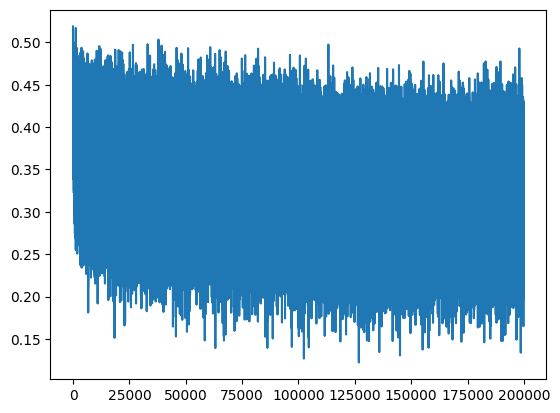

In [93]:
plt.plot(lossi);

In [97]:
# batch norm happens on batches of data, but inference doesn't happen in batches;
# hence, calculate the mean & std on the entire training set

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1

    bnmean = h_preact.mean(0, keepdim=True)
    bnstd = h_preact.std(0, keepdim=True)

# bnmean, bnmean_running
# bnstd, bnstd_running

In [98]:
@torch.no_grad  # disable gradient tracking
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xte, Yte)}[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1
    # we don't want mean & std to vary for the splits. training vals are what matter.
    # h_preact = bngain * (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + bnbias
    h_preact = bngain * (h_preact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.065549850463867
val 2.111138343811035


In [61]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        h_preact = embcat @ W1 + b1
        h = torch.tanh(h_preact)
        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


In [ ]:
# pytorchify this setup

In [104]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out - x @ self.weight

        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params (training with backprop)
        self.gamma = torch.ones(dim)  # gain
        self.beta = torch.zeros(dim)  # bias
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + xvar

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # dimensions of a character embeddings vector
n_hidden = 100  # neurons in a hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # make the last layer a bit less confident
    layers[-1].weight *= 0.1
    # apply gain to the other linear layers
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497
